## TA Review 8
Tobias


### 0. Midterm Tips
Good job, I saw a lot more people follow some of the tips about skipping questions, etc.

### 1. Probability of Outperformance (Math)

Review of some equations:

Given some series of **i.i.d** log-returns 

$$
r_i \sim N(\mu, \sigma^2)
$$

We can estimate the sample mean and sample standard deviation as:

$$
\hat{\mu} = \frac{1}{n} \sum_{i=1}^n r_i
$$

$$
\hat{\sigma}^2 = \frac{1}{n-1} \sum_{i=1}^n (r_i - \hat{\mu})^2
$$

Note: for this class, we will use the population variance (note that this is--inexplicably--the default behavior in numpy and pandas):

$$
\hat{\sigma}^2 = \frac{1}{n} \sum_{i=1}^n (r_i - \hat{\mu})^2
$$

What did we mean by convergence? We mean that as $n$ gets large, the sample mean converges to the population mean, and we get *more* confident in our estimate of the population mean. Graphically, what does this look like?

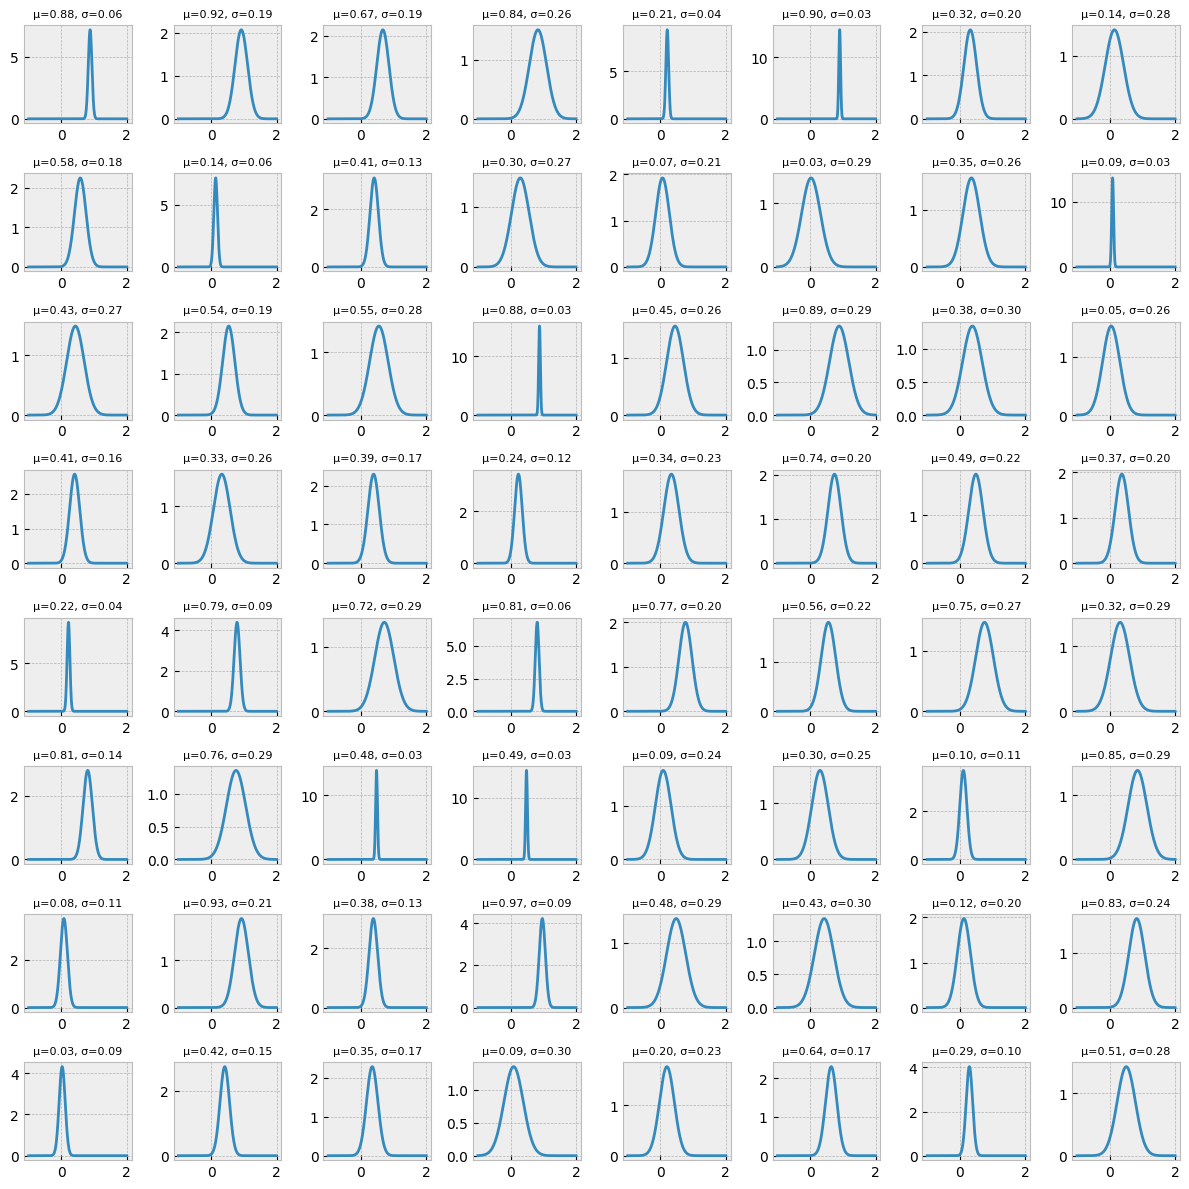

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

plt.style.use('bmh')

# Set random means and standard deviations
means = np.random.uniform(0.01, 1, size=(8, 8))
stds = np.random.uniform(0.01, 0.3, size=(8, 8))

# Generate x values for plotting
x = np.linspace(-1, 2, 500)  # Covers a range suitable for most distributions

# Plot the PDFs
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
for i in range(8):
    for j in range(8):
        # Create a normal distribution
        pdf = norm.pdf(x, loc=means[i, j], scale=stds[i, j])
        
        # Plot the PDF
        axes[i, j].plot(x, pdf)
        axes[i, j].set_title(f"μ={means[i, j]:.2f}, σ={stds[i, j]:.2f}", fontsize=8)

plt.tight_layout()
plt.show()

What are we trying to approximate? We're trying to guess *which* distribution we are drawing from. Our "best guess" of this is the sample mean and sample standard deviation.

Why? Because we're assuming log-returns are normal i.i.d -- so we know the normal distribution is parameterized by the mean and standard deviation, and we can't really do better than that.

(Note: in higher dimensions, we can actually do better than this -- via James-Stein estimator, for example -- but that's a topic for another day.)

The *core* idea here is that as we draw more and more samples from this distribution, we get more and more confident that this is the distribution we're drawing from.

Limitations: thoughts?

### 1.2 Probability of Outperformance (Finance)

1. What is risk?
2. Why does our risk *increase* even as we become *more* confident in our estimate of the mean and standard deviation?

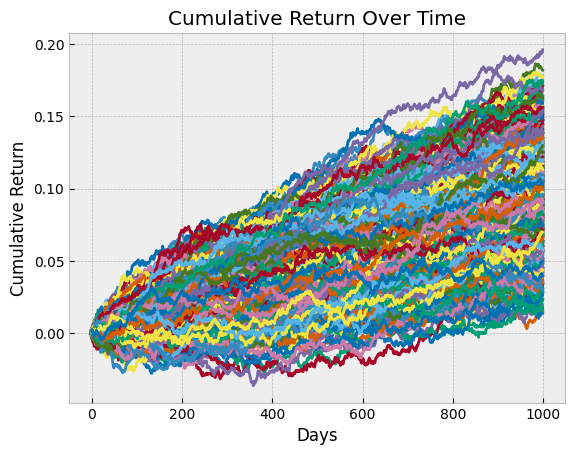

In [2]:
# Draw 1000 from the same distributions and take the cumulative sum
mean = 0.0001
std = 0.001

samples = np.random.normal(mean, std, size=(1000, 1000))
cumsum = np.cumsum(samples, axis=0)

# Plot the cumulative sum
plt.plot(cumsum)
plt.xlabel('Days')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return Over Time');

Does the above look riskless? All of these paths are drawn from the same distribution.

Why does this happen? Because our total capital is growing -- and we are increasing the standard deviation.

Another way to see this, we have a portfolio of bets -- $r_0, r_1, \dots, r_i$.

What is our total return?

$$
R = \sum_{i=0}^n r_i = n \hat{\mu}
$$

And what is the variance of our total return?

$$
\sigma^2_R = \sum_{i=0}^n \sigma^2 = n \hat{\sigma}^2
$$

What is the *distribution* of all of these return paths? Normal!

$$
R \sim N(n \mu, n \sigma^2)
$$

Thus, if we want to figure out what the probability of $R < X$, we can use the normal distribution. Let $\Phi$ be the CDF of the standard normal distribution, and $\Phi_{n}$ be the CDF of the normal distribution with mean $n \mu$ and variance $n \sigma^2$.

\begin{align*}
\mathbb{P}(R < X) &= \Phi_{n}\left(X\right)\\
&= \Phi\left(\frac{X - n \mu}{\sqrt{n} \sigma}\right)
\end{align*}


And finally, in the case where $X = 0$, this simplifies to:
$$
\Phi\left(\frac{n \mu}{\sqrt{n} \sigma}\right) = \Phi\left(\sqrt{n} \frac{\mu}{\sigma}\right)
$$

### 1.3 Calculating the Probabilities

Conceptually, we're trying to project the graph that we saw into the future. Let's give an example visually.

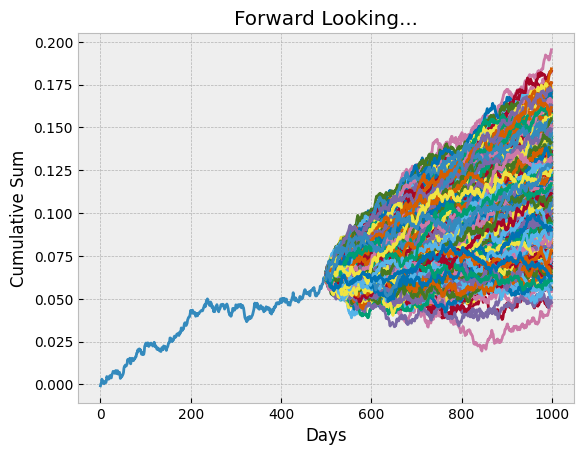

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mean = 0.0001
std = 0.001

# Generate the first path
path = np.random.normal(mean, std, size=500)
cumsum = np.cumsum(path)

# Calculate mean and standard deviation of the first path
path_mean = np.mean(path)
path_std = np.std(path)

# Generate multiple paths (1000) starting at the end of the first path
path2 = np.random.normal(mean, std, size=(500, 1000))
path2_cumsum = np.cumsum(path2, axis=0)
path2_cumsum = cumsum[-1] + path2_cumsum

# Plot the first path and the subsequent paths
plt.plot(cumsum)
for i in range(path2_cumsum.shape[1]):
    plt.plot(np.arange(500, 1000), path2_cumsum[:, i])

plt.title("Forward Looking...")
plt.xlabel("Days")
plt.ylabel("Cumulative Sum")
plt.show()


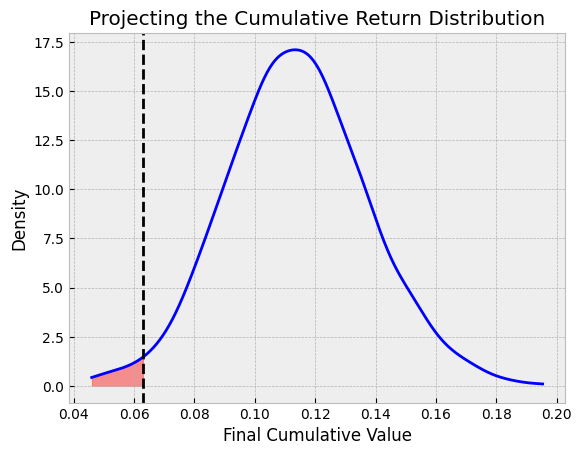

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Clean the final cumulative values to remove NaN or inf
final_cumulative_values = path2_cumsum[-1, :]

# Last cumulative return of the first path
last_cumulative_return = cumsum[-1]

# Compute KDE using gaussian_kde
kde = gaussian_kde(final_cumulative_values)
x_vals = np.linspace(min(final_cumulative_values), max(final_cumulative_values), 1000)
y_vals = kde(x_vals)

# Plot the KDE
plt.plot(x_vals, y_vals, color="blue", label="Final Values Distribution",)

# Highlight region below the last cumulative return
mask = x_vals <= last_cumulative_return
plt.fill_between(x_vals[mask], y_vals[mask], color="red", alpha=0.4, label="Below First Path Final Return")

# Add a vertical line for the last cumulative return of the first path
plt.axvline(last_cumulative_return, color="black", linestyle="--", label="First Path Final Return")

# Annotations
plt.title("Projecting the Cumulative Return Distribution")
plt.xlabel("Final Cumulative Value")
plt.ylabel("Density")
plt.show()

Above is a Gaussian KDE, but let's simplify this to a normal distribution.

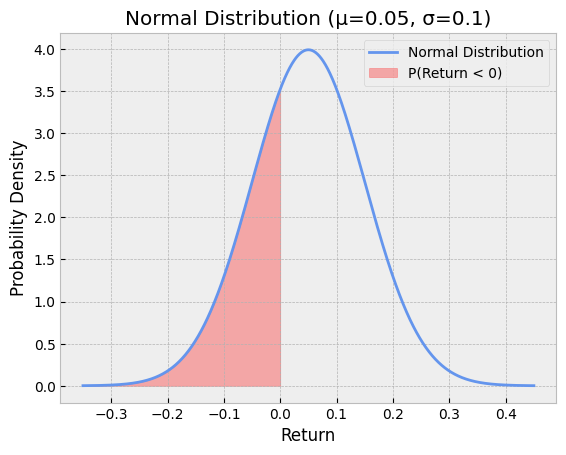

In [5]:
# Parameters
mean = 0.05
std = 0.1

# Generate x values for the range of the distribution
x = np.linspace(mean - 4 * std, mean + 4 * std, 1000)
pdf = norm.pdf(x, loc=mean, scale=std)

# Plot the normal distribution
plt.plot(x, pdf, label='Normal Distribution', color='cornflowerblue')

# Highlight the region where x < 0
x_fill = np.linspace(x[0], 0, 500)
pdf_fill = norm.pdf(x_fill, loc=mean, scale=std)
plt.fill_between(x_fill, pdf_fill, color='red', alpha=0.3, label='P(Return < 0)')

# Add labels, legend, and title
plt.title(f"Normal Distribution (μ={mean}, σ={std})")
plt.xlabel('Return')
plt.ylabel('Probability Density')
plt.legend();

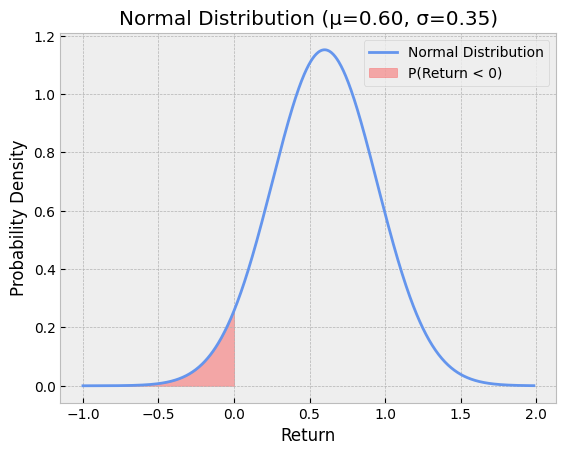

In [6]:
# Not do the same distribution scaled by 12
mean_12 = 0.05 * 12
std_12 = 0.1 * np.sqrt(12)

# Generate x values for the range of the distribution
x = np.linspace(-1 , mean_12 + 4 * std_12, 1000)
pdf = norm.pdf(x, loc=mean_12, scale=std_12)

# Plot the normal distribution
plt.plot(x, pdf, label='Normal Distribution', color='cornflowerblue')

# Highlight the region where x < 0
x_fill = np.linspace(x[0], 0, 500)
pdf_fill = norm.pdf(x_fill, loc=mean_12, scale=std_12)
plt.fill_between(x_fill, pdf_fill, color='red', alpha=0.3, label='P(Return < 0)')

# Add labels, legend, and title
plt.title(f"Normal Distribution (μ={mean_12:.2f}, σ={std_12:.2f})")
plt.xlabel('Return')
plt.ylabel('Probability Density')
plt.legend();

### 1.4 What about spreads?

What if we have a spread? What if we have two assets, $r_1$ and $r_2$, and we want to know the probability that $r_1$ outperforms $r_2$?

What is the distribution of $r_1 - r_2$?

$$
r_1 - r_2 \sim N(\mu_1 - \mu_2, \sigma_1^2 + \sigma_2^2)
$$

.

.

.

.

.

.

.

.

.

.

.

.

.

.


No! Why? Because of the correlation between the two assets. The correct distribution is:

$$
r_1 - r_2 \sim N(\mu_1 - \mu_2, \sigma_1^2 + \sigma_2^2 - 2 \rho \sigma_1 \sigma_2)
$$

Or, said in an easier way:

$$
\text{Var}(r_1 - r_2) = \text{Var}(r_1) + \text{Var}(r_2) - 2 \text{Cov}(r_1, r_2)
$$

Therefore, we can't approximate the volatility of the spread as $\sqrt{\sigma_1^2 + \sigma_2^2}$ -- we need to take into account the correlation between the two assets.

Once we have this distribution, we can calculate the probability that $r_1$ outperforms $r_2$ in the same way as before.

$$
\mathbb{P}(r_1 - r_2 < 0) = \Phi\left(\frac{\mu_1 - \mu_2}{\sqrt{\sigma_1^2 + \sigma_2^2 - 2\text{Cov}(r_1, r_2)}}\right)
$$

With that information, lets take a look at Midterm 2 solutions.

In [7]:
# Use of list slicing also applies to strings, and DataFrames!
# Think about why this might be the case. What is the general concept
# that allows us to both loop through something and also slice it?

my_list = [i for i in range(10)]

# Get the first 5 elements
my_list[:5]

# Get last 5 elements
my_list[-5:]

# Get the middle 5 elements
my_list[2:7]

# Get every second element
my_list[::2]

# Get every second element starting from 3
my_list[3::2]

# Reverse the list
my_list[::-1]

# Get the first 5 elements, but in reverse
my_list[4::-1]

# Note how this works for DataFrames as well!
my_df = pd.DataFrame(np.random.randn(10, 5), columns=[f"Col {i}" for i in range(5)])

# Same as with the df
my_df.iloc[:5]
my_df.iloc[-5:]
my_df.iloc[2:7]
my_df.iloc[::2]
my_df.iloc[3::2]
my_df.iloc[::-1]
my_df.iloc[4::-1]

# etc.

my_list.__getitem__(slice(0, 5, 1))
my_df.__getitem__(slice(0, 5, 1));

In [8]:


# Let's say I'm fed up of not being able to slice my dictionary, after all,
# who uses integers as keys anyway? I want to be able to do something like:

d = {"a": 1, "b": 2, "c": 3}
d[0:2]

# :(



TypeError: unhashable type: 'slice'

In [9]:
class SliceyDict(dict):
    def __getitem__(self, key):
        if isinstance(key, slice):
            if isinstance(key.start, int):
                return {k: self[k] for k in list(self.keys())[key]}
            elif isinstance(key.start, str):
                return {k: self[k] for k in list(self.keys())[list(self.keys()).index(key.start):list(self.keys()).index(key.stop) + 1]}
        else:
            return super().__getitem__(key)
        
d = SliceyDict({"a": 1, "b": 2, "c": 3})
display(d[0:2])
display(d["a":"c"])

{'a': 1, 'b': 2}

{'a': 1, 'b': 2, 'c': 3}

In [10]:
# Why might this be a bad idea?
# Hint: https://github.com/python/cpython/blob/main/Objects/dictobject.c
# What is the extension of this file?

# Also
for i in range(10):
    ...
    
for i in range(10):
    pass



In [11]:
type(...)

ellipsis